# Ranking: Priority Inbox
## Introduction
**Note: This is a very basic implementation with probably a lot of inefficient and redundant code. I might refactor the code later to improve performance and reduce result variation from the book. Feel free to suggest improvements via GitHub Issues.**

This notebook is an implementation of the weight based Ranking Algorithm from O'Reilly Media's Machine Learning for Email using Python. The Algorithm uses different aspects of the emails such as the sender details, thread activity, temporal analysis and frequent terms analysis. We will only use the ham messages from the publicly available dataset from [SpamAssassin Public Corpus](http://spamassassin.apache.org/publiccorpus/).

To begin with, we will import some modules. We use pandas for loading emails and manipulating dataframes, numpy for some mathematical functions, matplotlib for plotting, nltk for text processing, sklearn for feature extraction, email for parsing raw email, and re for regular expressions.

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, re, email
import nltk
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

The data is located inside the `/data` directory from the current directory. You need to extract the two archives inside the data directory before you can load the emails. Make sure that the data is extracted in respected directory i.e. `easy_ham` and `hard_ham` directories.

In [4]:
data = os.curdir + '/data/'
easy_ham_dir = data + '/easy_ham/'
hard_ham_dir = data + '/hard_ham/'

Then, we will load each file from the `/data/easy_ham` and `/data/hard_ham` directories to a list. Note that the files are encoded in latin so `encoding=latin1` is used while opening the file. The email module then takes each file and gives an email message object which is appended to the respective list.

In [5]:
easy_ham = []
hard_ham = []
for file_name in os.listdir(easy_ham_dir):
    easy_ham.append(email.message_from_file(open(easy_ham_dir + file_name, 'r', encoding='latin1')))
for file_name in os.listdir(hard_ham_dir):
    hard_ham.append(email.message_from_file(open(hard_ham_dir + file_name, 'r', encoding='latin1')))

We will create a dictionary with the features we will extract as the key. `from` gives the sender's email address, `date` is the date when the email was sent, `subject` gives the email's subject and `message` is the email's message content.

In [6]:
features_easy_ham = {
    'from': [],
    'date': [],
    'subject': [],
    'message': []   
}

The email module parses each file from the `easy_ham` list and extracts information about the sender, the email sent date, email subject and email's message content which are inserted to the `features_easy_ham` dictionary.

In [7]:
# TODO: Too messy, Clean the code
for email_ in easy_ham:
    features_easy_ham['from'].append(email_.get('from'))
    features_easy_ham['date'].append(email_.get('date'))
    features_easy_ham['subject'].append(email_.get('subject'))
    message = email_.get_payload()
    if type(message) == type([]):
        message = message[0].get_payload()
        if type(message) == type([]):
            message = message[0].get_payload()
            if type(message) == type([]):
                message = message[0].get_payload()
    features_easy_ham['message'].append(message)

Now, we use the `pd.DataFrame.from_dict()` method to create a dataframe from the `feature_easy_ham` dictionary. Let's check out some of the email records.

In [8]:
easy_ham = pd.DataFrame.from_dict(features_easy_ham)
easy_ham.head()

,from,date,subject,message
0,Robert Elz <kre@munnari.OZ.AU>,"Thu, 22 Aug 2002 18:26:25 +0700",Re: New Sequences Window,"Date: Wed, 21 Aug 2002 10:54:46 -05..."
1,Steve Burt <Steve_Burt@cursor-system.com>,"Thu, 22 Aug 2002 12:46:18 +0100",[zzzzteana] RE: Alexander,"Martin A posted:\nTassos Papadopoulos, the Gre..."
2,"""Tim Chapman"" <timc@2ubh.com>","Thu, 22 Aug 2002 13:52:38 +0100",[zzzzteana] Moscow bomber,Man Threatens Explosion In Moscow \n\nThursday...
3,Monty Solomon <monty@roscom.com>,"Thu, 22 Aug 2002 09:15:25 -0400",[IRR] Klez: The Virus That Won't Die,Klez: The Virus That Won't Die\n \nAlready the...
4,Tony Nugent <tony@linuxworks.com.au>,"Thu, 22 Aug 2002 23:36:32 +1000",Re: Insert signature,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wrot..."


From above table, we can clearly see different informations of the emails. But, it is far from being usable in our Algorithm. We will extract only the email address from the `from` column. The items in `date` column are string but for time analysis, we will need to convert it to proper format. But, first, let's remove the duplicate rows from the dataframe. We have the `drop_duplicates()` method for this. It seems that more than hundred redundant records existed in the dataset.

In [9]:
print(easy_ham.shape)
easy_ham = easy_ham.drop_duplicates()
print(easy_ham.shape)

(2551, 4)
(2437, 4)


## Data Pre-processing

Now, we will use regular expression on the `from` column to extract only the email address. It will grab email addresses in two formats: \<abc@xxx.net> and abc@xxx.net. we will need to further process the first type of email for uniformity. We can use the `str.extract()` method to extract the emails.

In [10]:
email_regex = r"(\S+@\S+)"
email_regex = re.compile(email_regex)

In [11]:
easy_ham['from'] = easy_ham['from'].str.extract(email_regex)

Now, we will check if an email starts with '<'. If it does, we will drop it and append it to a list. Then, we will update the `from` column with the newly processed data.

In [12]:
easy_ham_list = []
for matched_value in easy_ham['from']:
    final_value = matched_value
    if matched_value[0]=='<':
        final_value = matched_value[1:-1]
    easy_ham_list.append(final_value)

In [13]:
easy_ham['from'] = easy_ham_list

We will then convert all data to lowercase to increase uniformity. It will also make it easier to process text data.

In [14]:
easy_ham['from'] = easy_ham['from'].apply(str.lower)
easy_ham['subject'] = easy_ham['subject'].apply(str.lower)
easy_ham['message'] = easy_ham['message'].apply(str.lower)

By grouping the dataframe by the `from` column and sorting the values in descending order, we can observe the users who have sent the maximum number of emails. rssfeeds@example.com has the highest number which is 614. This is from RSS feeds and is probably not much useful for our Algorithm.

In [15]:
easy_ham.groupby('from').aggregate('count').sort_values('subject', ascending=False).head()

,date,subject,message
from,,,
rssfeeds@example.com,614,614,614
tomwhore@slack.net,55,55,55
pudge@perl.org,52,52,52
tim.one@comcast.net,45,45,45
garym@canada.com,42,42,42


We will remove all entries from rssfeeds@example.com

In [16]:
easy_ham = easy_ham[easy_ham['from']!='rssfeeds@example.com']
print(easy_ham.shape)

(1823, 4)


Now, we need to convert the string dates to a proper datetime format which can be used to analyze emails from perspective of time. For this, we will use pandas' `to_datetime()` method, which parses the string date to Timestamp format.

In [230]:
easy_ham.date = pd.to_datetime(easy_ham.date, infer_datetime_format=True)

We have finished our data cleaning and now we can prepare the dataset for our algorithm. We set the index to the `date` column so that we can order the emails according to the email date. Let's name the dataframe priority_df.

In [18]:
priority_df = easy_ham.set_index('date')
priority_df = priority_df.sort_index()
print(priority_df.shape)

(1823, 3)


Although, we have fixed a lot of issues, there still exist some outliers like the below where the indices are same.

In [19]:
priority_df.loc['2002-08-28 10:21:47']

,from,subject,message
date,,,
2002-08-28 10:21:47,yyyy@example.com,re: [satalk] setting up a spam eating address,"\n""steve thomas"" said:\n\n> i created a user (..."
2002-08-28 10:21:47,zzzz@example.com,re: [satalk] setting up a spam eating address,"\n""steve thomas"" said:\n\n> i created a user (..."


We will drop such records by keeping all records except the index duplicated.

In [20]:
priority_df = priority_df[~priority_df.index.duplicated(keep='first')]
print(priority_df.shape)

(1810, 3)


Now, we will create our training and testing dataset. Half of the original dataset will be our training dataset and the other half will be our testing dataset.

In [343]:
priority_train = priority_df.iloc[1:priority_df.shape[0]//2]
priority_test = priority_df.iloc[priority_df.shape[0]//2:]
print(priority_train.shape)
print(priority_test.shape)

(904, 3)
(905, 3)


In [22]:
priority_train.head()

,from,subject,message
date,,,
2002-02-01 06:53:41,lance_tt@bellsouth.net,re: please help a newbie compile mplayer :-),make sure you rebuild as root and you're in th...
2002-02-01 09:01:44,robinderbains@shaw.ca,re: please help a newbie compile mplayer :-),lance wrote:\n\n>make sure you rebuild as root...
2002-02-01 09:29:23,matthias@egwn.net,re: please help a newbie compile mplayer :-),"once upon a time, rob wrote :\n\n> i dl'd gcc..."
2002-02-01 13:00:22,harri.haataja@cs.helsinki.fi,http://apt.nixia.no/,title page has a login screen and i can't seem...
2002-02-01 14:35:41,matthias@egwn.net,re: http://apt.nixia.no/,"once upon a time, harri wrote :\n\n> title pag..."


## Weights Training
We will generate weights from different aspects of email. We will use five weighting schemes for our algorithm.

### Weights from sender information ('from')
First, we will generate weights from the frequency of email addresses. The email address with more number of emails will have greater weight.

In [303]:
from_weight = priority_train.groupby('from', as_index=False).subject.count()

The weights generated above have high variation so we will apply natural log to smooth the weights, and reduce the variation. The `transform()` method allows us to apply any function to the pandas Series. Here, `lambda x: np.log(x+1)` is applied to all item. As `log(0)` is undefined, we add 1 to make sure that this condition doesn't occur.

In [304]:
from_weight['weight'] = from_weight.subject.transform(lambda x: np.log(x+1))
from_weight.drop('subject', axis=1, inplace=True)

Let's checkout the email addresses with the highest frequency.

In [389]:
from_weight.sort_values('weight', ascending=False).head()

,from,weight
259,tim.one@comcast.net,3.610918
19,beberg@mithral.com,3.178054
171,matthias@egwn.net,3.091042
262,tomwhore@slack.net,3.091042
243,skip@pobox.com,3.044522


### Weights from thread analysis
Now, we will generate weights matrices for thread activity in the emails. From threads, we will generate three weights matrices, the first being weights from sender information in threads.
#### Weights from sender in threads
In this weighting scheme, we will apply the same method as from weight to obtain the weights of frequent senders in threads.

First of all, we will determine which of the emails are threads. We can do this by checking if the email subject contains the expression `re: `. Then, we can split the full subject `re: {subject}` to obtain the `{subject}` only part.

In [26]:
is_thread = priority_train.subject.str.contains('re: ')

In [27]:
threads = priority_train[is_thread]
re_subject_split = threads.subject.str.split('re: ')

We obtain the list of senders in threads by passing the is_thread variable to our priority_train dataframe.

In [28]:
sender_thread = priority_train['from'][is_thread]

We, then, extract the subject only part and append them to a response list.

In [29]:
response_thread = []
for split_subj in re_subject_split:
    response_thread.append(split_subj[1])

In [30]:
sender_thread = list(sender_thread)

We then obtain a dataframe with the list of senders active in each thread activity.

In [31]:
thread_matrix = pd.DataFrame([sender_thread, response_thread])

Now, to obtain the senders weight matrix, we take the list of senders and count their frequency. As before, we apply log transformation to smooth out the result.

In [32]:
senders = thread_matrix.iloc[0, :]
senders_freq = senders.groupby(senders).count()

In [33]:
senders_wt = senders_freq.transform(lambda x: pd.np.log(x+1))

Let's create a dictionary with all the values, and use it to obtain out senders weight dataframe.

In [34]:
senders_dict = {
    'from': senders_freq.index.tolist(),
    'freq': list(senders_freq.values),
    'weight': list(senders_wt)
}

In [307]:
senders_weight = pd.DataFrame(senders_dict)

The senders weight matrix contains the senders list with respective weight assigned to each user.

In [308]:
senders_weight.head()

,from,freq,weight
0,adam@homeport.org,1,0.693147
1,aeriksson@fastmail.fm,5,1.791759
2,albert.white@ireland.sun.com,1,0.693147
3,andr@sandy.ru,1,0.693147
4,andris@aernet.ru,1,0.693147


#### Weights from thread subjects and thread activity
In this weighting scheme, we will determine the frequently active threads and assign weights to each thread on the basis of thread activity.
First, let's extract thread subjects from thread matrix.

In [37]:
threads_sub = thread_matrix.iloc[1, :].unique()

Now, let's create a dataframe to store the thread weights. To determine the weight of the thread we look at two things. The first being the thread frequency i.e how frequently the thread occur in the training dataset. For this we obtain the dates of the emails, which contain the thread subject, either the subject only or the replied email i.e `re: subject`. Then, counting the number of results we can obtain the thread frequency.

Secondly, we check the time span of the emails in the threads. For this, we subtract the minimum value of the date from the maximum value, and obtain the number of seconds for each thread.

And, finally, we generate the weights from the above information. In this case, we obtain weight as `weight = frequency/time` as we want to find how much thread activity is there in each second. The weight is 1 when an email is sent every second. 

Usually, the time span is much larger than the thread frequency. And, we obtain negative weights after applying log. So, we will apply `affine transformation` to the weights to make sure that the weights obtained are positive. For this, we apply log (base-10) to every weight and add 10 to it. This ensures that the weights remain positive.

Here, the if condition checks the frequency. If a thread occurs only once, then it's not useful to us for thread analysis. So, we append NaN to all thread weights in which thread occurs only once. Otherwise, we apply above calculations.

In [95]:
thread_counts = pd.DataFrame(data=[], columns=['freq', 'time_span', 'weight'])

for thread in threads_sub:
    thread_times = priority_train.index[priority_train.subject.str.contains(thread, regex=False) | priority_train.subject.str.contains('re: ' + thread, regex=False)]
    thread_freq = len(thread_times)
    min_time = thread_times.min()
    max_time = thread_times.max()
    time_span = (max_time - min_time).seconds
    if thread_freq<2:
        thread_counts = thread_counts.append({
            'freq': np.nan,
            'time_span': np.nan,
            'weight': np.nan,
        }, ignore_index=True)
    else:
        weight = thread_freq / time_span
        log_weight = 10 + np.log10(weight)
        thread_counts = thread_counts.append({
            'freq': thread_freq,
            'time_span': time_span,
            'weight': log_weight,
        }, ignore_index=True)

0


In [39]:
thread_weights = thread_counts
thread_weights['thread'] = threads_sub

Then, we drop all NaN values to clean the data. Finally, we obtain the thread_weights dataframe containing all thread list with respective frequency, time span and weight. 

In [41]:
thread_weights = thread_weights.dropna()

In [200]:
thread_weights.head()

,freq,time_span,weight,thread
0,3.0,9342.0,6.506681,please help a newbie compile mplayer :-)
1,10.0,6103.0,7.214457,http://apt.nixia.no/
2,4.0,12114.0,6.518772,prob. w/ install/uninstall
3,3.0,38104.0,5.896151,problems with 'apt-get -f install'
4,2.0,49547.0,5.606013,problems with apt update


#### Weights from frequent terms in thread subject
In this weighting scheme, we extract the frequent terms present in the thread subjects. To extract the terms, we will use the `CountVectorizer` from `sklearn`. The stopwords are supplied from the nltk corpus.
The `CountVectorizer` can be used to fit the thread subjects to generate the term document matrix.

In [108]:
# Uncomment if error occurs
# nltk.download('stopwords')
vec = CountVectorizer(encoding='latin1', stop_words=nltk.corpus.stopwords.words('english'))
thread_term_vector = vec.fit_transform(thread_weights.thread)

The term document matrix consists of all the terms obtained from the threads subjects and their frequency.

In [130]:
thread_tdm = pd.DataFrame(thread_term_vector.toarray(), columns=vec.get_feature_names())

Using the frequent terms from the term document matrix, we can obtain the term weights. We check for the term in each thread and take the mean of all the thread weights which contain that term. This mean will be the weight for that term.

In [139]:
term_weights = []
for term in thread_tdm.columns:
    weight = thread_weights.weight[thread_weights.thread.str.contains(term, regex=False)].mean()
    term_weights.append(weight)

In [140]:
thread_term_weights = pd.DataFrame.from_dict({
    'term': thread_tdm.columns,
    'weight': term_weights
})

From above dictionary, we obtain the dataframe for the weights for the thread terms. Some, of the least used terms are below.

In [261]:
thread_term_weights.sort_values('weight', ascending=True).head()

,term,weight
226,postfix,5.412918
287,source,5.424068
200,notes,5.438219
168,lotus,5.438219
245,recreations,5.543614


Similarly, if we check the terms with highest we obtain the following terms. All the following terms belong to a single email thread outlier.

In [643]:
thread_term_weights.sort_values('weight', ascending=False).head()

,term,weight
251,removal,9.69897
33,bug,9.69897
5,840,9.69897
289,spam_level_char,9.69897
207,option,9.69897


From below, you can see that there are two emails in this thread and the time span is only 4 seconds, which means that someone replied to the email 4 seconds after it was sent. Because of this, the weight obtained is high and since all terms take mean of a single weight, their weights are also high. This type of email could have been generated by a server.

In [644]:
thread_weights[thread_weights.thread.str.contains('spam_level_char')]

,freq,time_span,weight,thread
193,2.0,4.0,9.69897,[sadev] [bug 840] spam_level_char option chang...


Now, we have completed our thread analysis and we continue to our final weighting techinque.

### Weights from frequent terms in messages
In this weighting scheme, we generate frequent terms from the whole message content. As above, we feed the message contents from our training dataset to our `CountVectorizer` which will generate the term document matrix for our email messages.

In [250]:
# TODO: Strip message of punctuations and numbers before extracting terms
msg_terms = vec.fit_transform(priority_train.message)

In [251]:
msg_tdm = pd.DataFrame(msg_terms.toarray(), columns=vec.get_feature_names())

We generate the message term weights dataframe with the terms from the term document matrix and term weights as the natural log of the frequency of each term.

In [252]:
msg_term_weights = pd.DataFrame.from_dict({
    'term': msg_tdm.columns,
    'weight': np.log(msg_tdm.sum()),
})
msg_term_weights.index = range(msg_term_weights.shape[0])

Now, we remove all terms with zero weights.

In [253]:
msg_term_weights = msg_term_weights[msg_term_weights.weight > 0]

The final weight matrix for our algorithm has been obtained. Now, we can start working on our algorithm.

In [259]:
msg_term_weights.sort_values('weight', ascending=False).head()

,term,weight
3583,com,7.192934
7350,http,7.078342
9800,net,6.916715
8666,list,6.836259
8680,lists,6.568078


## Training the Algorithm
Now, we need to train our dataset with the obtained weight matrices to obtain the rank. The rank is obtained as the product of all the weight values from each weight matrix.

For this, we start with defining a function `get_weights()` to obtain the weights for terms in email if they do not map to a single term weight matrix. This is requred in cases when the email contains new terms which do not exist in our term weight matrices.

In this function, we try to obtain weights for the thread terms. The parameter `term` determines if we are looking for weight from the thread_weights matrix or from term_weights matrix.

For thread, `term=False`, and the thread subject is matched with previously available threads and the mean of the matched weights is returned.

For term list, `term=True`, and each term from the list is compared with one in the term matrix, then every term's result is OR'ed with the previous result to obtain the final match. Then, the mean of the matched weights is returned.

If no match is found for either, a weight of 1 is returned as it doesn't alter the weight product.

In [457]:
def get_weights(search_term, weight_df, term=True):
    search_term = str(search_term)
    if (len(search_term)>0):
        if term:
            term_match = False
            for search_item in search_term:
                match = weight_df.term.str.contains(search_item, regex=False)
                term_match = term_match | match
        else:
            term_match = weight_df.thread.str.contains(search_term, regex=False)
        
        match_weights = weight_df.weight[term_match]
        if len(match_weights)<1:
            return 1
        else:
            return match_weights.mean()
    else:
        return 1

The main step of our Algorithm is the `rank_message()` function which generates the rank for each email message.

In this function, the weights from each weight matrix is obtained for the email message passed to the function. The final rank is calculated as the product of all five weights.

This function returns a list containing the email's date, email's sender, it's subject and the generated rank of the email.

In [615]:
# TODO: Increase efficiency
def rank_message(msg):
    # First, using the from weights
    from_wt = from_weight[from_weight['from']==msg['from']]
    if len(from_wt)>0:
        msg_from_wt = from_wt.weight
    else:
        msg_from_wt = 1
    
    # Second, using senders weights from threads
    senders_wt = senders_weight[senders_weight['from']==msg['from']]
    if len(senders_wt)>0:
        msg_thread_from_wt = senders_wt.weight
    else:
        msg_thread_from_wt = 1
        
    # Then, from thread activity
    is_thread = len(msg.subject.split('re: ')) > 1
    if is_thread:
        subject = msg.subject.split('re: ')[1]
        msg_thread_activity_wt = get_weights(subject, thread_weights, term=False)
    else:
        msg_thread_activity_wt = 1
        
    # Then, weights based on terms in threads
    try:
        sub_vec = vec.fit_transform([msg['subject']])
        msg_thread_terms = vec.get_feature_names()
        msg_thread_term_wt = get_weights(msg_thread_terms, thread_term_weights)
    except:
        # Some subjects from the test set result in empty vocabulary
        msg_thread_term_wt = 1
    
    # Then, weights based on terms in message
    try:
        msg_vec = vec.fit_transform([msg['message']])
        msg_terms = vec.get_feature_names()
        msg_terms_wt = get_weights(msg_terms, msg_term_weights)
    except:
        # Some subjects from the test set result in empty vocabulary
        msg_terms_wt = 1
    
    # Calculating Rank
    rank = float(msg_from_wt) * float(msg_thread_from_wt) * float(msg_thread_activity_wt) * float(msg_thread_term_wt) * float(msg_terms_wt)
    
    return [msg.name, msg['from'], msg['subject'], rank]

### Training on training set
rank_dict dictionary is created to store the values of the rank dataframe for each iteration. An email from the priority_train training set is fed to the `rank_message()` function which returns the list with the email rank, which is appended to the rank_dict dictionary.

In [559]:
rank_dict = {
    'date': [],
    'from': [],
    'subject': [],
    'rank': []
}

for i in range(priority_train.shape[0]):
    result = rank_message(priority_train.iloc[i, :])
    rank_dict['date'].append(result[0])
    rank_dict['from'].append(result[1])
    rank_dict['subject'].append(result[2])
    rank_dict['rank'].append(result[3])

The rank_df dataframe is obtained from the dictionary which contains the generated rank of each email message.

In [561]:
rank_df = pd.DataFrame.from_dict(rank_dict)

Now, we need a threshold to determine if an email should be prioritized or not. In this algorithm, we will use the median of the generated ranks, but we can also use other metrics.

In [645]:
priority_threshold = rank_df['rank'].median()
print(priority_threshold)

54.82322210358363


A message is prioritized only if it's rank is higher than the priority threshold.

In [565]:
rank_df['priority'] = rank_df['rank'] > priority_threshold

Let's checkout some of the rank generated by our algorithm in the training set.

In [567]:
rank_df.head()

,date,from,subject,rank,priority
0,2002-02-01 06:53:41,lance_tt@bellsouth.net,re: please help a newbie compile mplayer :-),387.937501,True
1,2002-02-01 09:01:44,robinderbains@shaw.ca,re: please help a newbie compile mplayer :-),35.150163,False
2,2002-02-01 09:29:23,matthias@egwn.net,re: please help a newbie compile mplayer :-),699.140882,True
3,2002-02-01 13:00:22,harri.haataja@cs.helsinki.fi,http://apt.nixia.no/,57.021220,True
4,2002-02-01 14:35:41,matthias@egwn.net,re: http://apt.nixia.no/,777.017481,True


The below histogram shows that most of the emails lie in the lower end of the ranks. But still a lot of emails exist in the region greater than the priority_threshold. so, it has labeled many emails as important but still most of the emails are in non important region. So, this should be good.

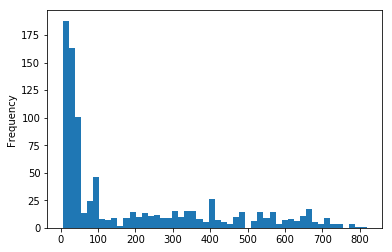

In [577]:
rank_df['rank'].plot.hist(bins=50)

Similarly, the density plot shows a peak around the region less than the median so maximum of the emails are non prioritized. And, the curve smooths out further to show the density of emails being prioritized.

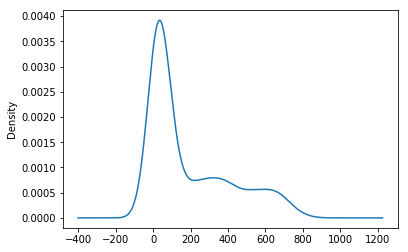

In [575]:
rank_df['rank'].plot.density()

### Testing on testing set
For this, we repeat the steps as for the training dataset. In the testing, we use the weight matrices generated from the training set on emails which are unseen by the weighting algorithms.

In [616]:
test_rank_dict = {
    'date': [],
    'from': [],
    'subject': [],
    'rank': []
}

for i in range(priority_test.shape[0]):
    result = rank_message(priority_test.iloc[i, :])
    test_rank_dict['date'].append(result[0])
    test_rank_dict['from'].append(result[1])
    test_rank_dict['subject'].append(result[2])
    test_rank_dict['rank'].append(result[3])

In [617]:
test_rank_df = pd.DataFrame.from_dict(test_rank_dict)

We obtain the priority_threshold, which is the median, as below.

In [646]:
priority_threshold = test_rank_df['rank'].median()
print(priority_threshold)

23.394583730328293


In [619]:
test_rank_df['priority'] = test_rank_df['rank'] > priority_threshold

Now, let's observe some of the emails prioritized by our algorithms in the testing dataset. By comparing with the output in the book, the algorithm seems to work decently.

In [638]:
test_rank_df[test_rank_df.priority].tail(10)

,date,from,subject,rank,priority
856,2002-10-08 23:17:04,tomwhore@slack.net,re: the disappearing alliance,96.529462,True
858,2002-10-09 00:02:08,johnhall@evergo.net,re: the disappearing alliance,41.881995,True
859,2002-10-09 01:19:49,ejw@cse.ucsc.edu,[nyt] korea's real rage for virtual games,40.042145,True
860,2002-10-09 02:00:25,pudge@perl.org,[use perl] headlines for 2002-10-09,33.181273,True
861,2002-10-09 02:00:35,pudge@perl.org,[use perl] stories for 2002-10-09,33.191858,True
882,2002-10-09 17:23:20,yyyy@example.com,re: [satalk] re: fully-public corpus of mail a...,647.257171,True
891,2002-10-09 19:58:04,jamesr@best.com,re: the disappearing alliance,54.268548,True
897,2002-10-10 02:00:35,pudge@perl.org,[use perl] stories for 2002-10-10,33.188456,True
899,2002-10-10 04:47:02,quinlan@pathname.com,re: [sadev] fully-public corpus of mail available,45.472497,True
903,2002-10-10 12:14:23,yyyy@example.com,re: [sadev] fully-public corpus of mail availa...,97.305191,True


As seen in the following histogram, most of the email lies towards the lowe ends. So, most of the email haven't been prioritized, which is good. Towards the higher weight range, very less emails exist which are prioritized.

Most of the emails have low weights probably due to unseen terms and threads in the training weights. It is clear that the training algorithm is unaware of the new data and the weighting matrices need to be updated for better results.

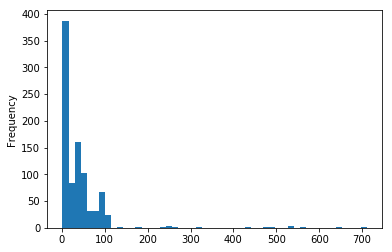

In [622]:
test_rank_df['rank'].plot.hist(bins=50)

Similarly, the following density plot also shows that most of the emails lie in the lower end. Besides, this plot is much steeper than the training plot. This indicates that the test data includes many observations not in our training data and the ranking algorithm effectively ignores the information as they do not match anything.

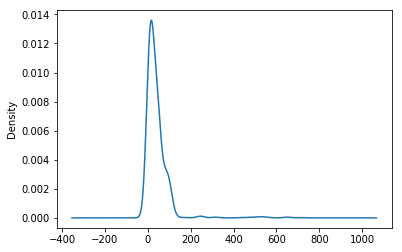

In [642]:
test_rank_df['rank'].plot.density()

# Conclusion
Through this notebook, we learnt how to develop a basic ranking algorithm for email messages. Email ranking is not like Classification problems where the output is defined and hence, there's not a proper metric for testing accuracy for such systems.

Since, the SpamAssassin dataset contains only one side of the conversation, we can't get the full picture of the situation and our algorithm might not function well in a real environment. The weights of the algorithms need to be regularly updated with new email messages for better accuracy.